In [1]:
import os
import pandas as pd
import cv2

In [2]:
from keras.layers.convolutional import Conv3D, ZeroPadding3D
from keras.layers.pooling import MaxPooling3D
from keras.layers.core import Dense, Activation, Dropout, Flatten, SpatialDropout3D
from keras.layers import Bidirectional, TimeDistributed
from keras.layers import BatchNormalization
#from keras.layers.recurrent import GRU
from keras.layers import GRU
from keras.layers import Input
from keras.models import Model
from keras import backend as K
from keras.layers.core import Lambda
from keras import backend as K
import tensorflow as tf

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [3]:
import numpy as np

In [4]:
x_data = np.load('train/x_data.npy') 
y_data = np.load('train/y_data.npy')

In [5]:
print(x_data.shape, y_data.shape)

(540, 5, 100, 200, 3) (540, 13)


In [6]:
input_shape = (5, 100, 200, 3)
output_size = 13
x = Input(name = 'the_input', shape = input_shape, dtype = 'float32')
print(x.shape)
x = ZeroPadding3D(padding = (1,2,2), name = 'zero1')(x)
print(x.shape)
x = Conv3D(32, (3,5,5), strides = (1,2,2), activation = 'relu', kernel_initializer = 'he_normal', name = 'conv1')(x)
print(x.shape)
x = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='max1')(x)
print(x.shape)
x = Dropout(0.5)(x)
print(x.shape)
print("=====================================================")
x = ZeroPadding3D(padding=(1, 2, 2), name='zero2')(x)
print(x.shape)
x = Conv3D(64, (3, 5, 5), strides=(1, 1, 1), activation='relu', kernel_initializer='he_normal', name='conv2')(x)
print(x.shape)
x = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='max2')(x)
print(x.shape)
x = Dropout(0.5)(x)
print(x.shape)
print("=====================================================")
x = ZeroPadding3D(padding=(1, 1, 1), name='zero3')(x)
print(x.shape)
x = Conv3D(96, (3, 3, 3), strides=(1, 1, 1), activation='relu', kernel_initializer='he_normal', name='conv3')(x)
print(x.shape)
x = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='max3')(x)
print(x.shape)
x = Dropout(0.5)(x)
print(x.shape) # (BN, 5, 6, 12, 96)
print("=====================================================")
x = TimeDistributed(Flatten())(x)
print(x.shape) # (BN, 5, 6912)
print("=====================================================")
x = Bidirectional(GRU(256, return_sequences=True, kernel_initializer='Orthogonal', name='gru1'), merge_mode='concat')(x)
print(x.shape)
x = Bidirectional(GRU(256, return_sequences=False, kernel_initializer='Orthogonal', name='gru2'), merge_mode='concat')(x)
print(x.shape)
print("=====================================================")
x = Dense(output_size, kernel_initializer='he_normal', name='dense1')(x)
print(x.shape)
print("=====================================================")
y_pred = Activation('softmax', name='softmax')(x)
print(y_pred.shape)

(None, 5, 100, 200, 3)
(None, 7, 104, 204, 3)
(None, 5, 50, 100, 32)
(None, 5, 25, 50, 32)
(None, 5, 25, 50, 32)
(None, 7, 29, 54, 32)
(None, 5, 25, 50, 64)
(None, 5, 12, 25, 64)
(None, 5, 12, 25, 64)
(None, 7, 14, 27, 64)
(None, 5, 12, 25, 96)
(None, 5, 6, 12, 96)
(None, 5, 6, 12, 96)
(None, 5, 6912)
(None, 5, 512)
(None, 512)
(None, 13)
(None, 13)


In [7]:
class Decoder(object):
    def __init__(self, greedy=True, beam_width=100, top_paths=1, **kwargs):
        self.greedy         = greedy
        self.beam_width     = beam_width
        self.top_paths      = top_paths
        self.language_model = kwargs.get('language_model', None)
        self.postprocessors = kwargs.get('postprocessors', [])

    def decode(self, y_pred, input_length):
        decoded = decode(y_pred, input_length, greedy=self.greedy, beam_width=self.beam_width,
                         top_paths=self.top_paths, language_model=self.language_model)
        preprocessed = []
        for output in decoded:
            out = output
            for postprocessor in self.postprocessors:
                out = postprocessor(out)
            preprocessed.append(out)

        return preprocessed
    
def decode(y_pred, input_length, greedy=True, beam_width=100, top_paths=1, **kwargs):
    language_model = kwargs.get('language_model', None)

    paths, logprobs = _decode(y_pred=y_pred, input_length=input_length,
                              greedy=greedy, beam_width=beam_width, top_paths=top_paths)
    if language_model is not None:
        # TODO: compute using language model
        raise NotImplementedError("Language model search is not implemented yet")
    else:
        # simply output highest probability sequence
        # paths has been sorted from the start
        result = paths[0]
    return result

In [8]:
from keras.layers.core import Lambda
from keras import backend as K

# Actual loss calculation
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # From Keras example image_ocr.py:
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    # y_pred = y_pred[:, 2:, :]
    y_pred = y_pred[:, :, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def CTC(name, args):
    return Lambda(ctc_lambda_func, output_shape=(1,), name=name)(args)

In [9]:
class LipNet(object):
    def __init__(self, img_c, img_w, img_h, frames_n, output_size):
        self.img_c = img_c
        self.img_w = img_w
        self.img_h = img_h
        self.frames_n = frames_n
        self.output_size = output_size
        self.build()
        
    def build(self):
        input_shape = (self.frames_n, self.img_w, self.img_h, self.img_c)
        #if K.image_data_format() == 'channels_first':
            #input_shape = (self.img_c, self.frames_n, self.img_w, self.img_h)
        #else:
            #input_shape = (self.frames_n, self.img_w, self.img_h, self.img_c)
        
        self.input_data = Input(name = 'the_input', shape = (5, 100, 200, 3), dtype = 'float32')
        self.zero1 = ZeroPadding3D(padding=(1, 2, 2), name='zero1')(self.input_data)
        self.conv1 = Conv3D(32, (3, 5, 5), strides=(1, 2, 2), kernel_initializer='he_normal', name='conv1')(self.zero1)
        self.batc1 = BatchNormalization(name='batc1')(self.conv1)
        self.actv1 = Activation('relu', name='actv1')(self.batc1)
        self.drop1 = SpatialDropout3D(0.5)(self.actv1)
        self.maxp1 = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='max1')(self.drop1)

        self.zero2 = ZeroPadding3D(padding=(1, 2, 2), name='zero2')(self.maxp1)
        self.conv2 = Conv3D(64, (3, 5, 5), strides=(1, 1, 1), kernel_initializer='he_normal', name='conv2')(self.zero2)
        self.batc2 = BatchNormalization(name='batc2')(self.conv2)
        self.actv2 = Activation('relu', name='actv2')(self.batc2)
        self.drop2 = SpatialDropout3D(0.5)(self.actv2)
        self.maxp2 = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='max2')(self.drop2)

        self.zero3 = ZeroPadding3D(padding=(1, 1, 1), name='zero3')(self.maxp2)
        self.conv3 = Conv3D(96, (3, 3, 3), strides=(1, 1, 1), kernel_initializer='he_normal', name='conv3')(self.zero3)
        self.batc3 = BatchNormalization(name='batc3')(self.conv3)
        self.actv3 = Activation('relu', name='actv3')(self.batc3)
        self.drop3 = SpatialDropout3D(0.5)(self.actv3)
        self.maxp3 = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='max3')(self.drop3)


        self.resh1 = TimeDistributed(Flatten())(self.maxp3)


        self.gru_1 = Bidirectional(GRU(256, return_sequences=True, kernel_initializer='Orthogonal', name='gru1'), merge_mode='concat')(self.resh1)
        self.gru_2 = Bidirectional(GRU(256, return_sequences=True, kernel_initializer='Orthogonal', name='gru2'), merge_mode='concat')(self.gru_1)

        # transforms RNN output to character activations:
        self.dense1 = Dense(self.output_size, kernel_initializer='he_normal', name='dense1')(self.gru_2)

        self.y_pred = Activation('softmax', name='softmax')(self.dense1)
        
        ####
        # y_true: (samples, max_string_length) : containing the truth labels
        # y_pred: (samples, time_steps, num_categories) : containing the prediction, or output of the softmax
        # input_length: (samples, 1): containing the sequence length for each batch item in y_pred
        # label_length: (samples, 1): containing the sequence length for each batch item in y_true
        ####
        self.labels = Input(name='the_labels', shape=[13], dtype='float32')
        self.input_length = Input(name='input_length', shape=[1], dtype='int64')
        self.label_length = Input(name='label_length', shape=[1], dtype='int64')

        self.loss_out = CTC('ctc', [self.y_pred, self.labels, self.input_length, self.label_length])

        self.model = Model(inputs=[self.input_data, self.labels, self.input_length, self.label_length], outputs=self.loss_out)
        
    def summary(self):
        Model(inputs = self.input_data, outputs = self.y_pred).summary()
        
    def predict(self, input_batch):
        return self.test_function([input_batch, 0])[0]  # the first 0 indicates test
    
    @property
    def test_function(self):
        # captures output of softmax so we can decode the output during visualization
        return K.function([self.input_data, K.learning_phase()], [self.y_pred, K.learning_phase()])

In [10]:
import keras
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True)

In [11]:
lipnet = LipNet(img_c=3, img_w=100, img_h=200, frames_n=5, output_size=13)
lipnet.summary()
adam = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
lipnet.model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=adam, metrics=['accuracy']) 

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, 5, 100, 200, 3)]  0         
                                                                 
 zero1 (ZeroPadding3D)       (None, 7, 104, 204, 3)    0         
                                                                 
 conv1 (Conv3D)              (None, 5, 50, 100, 32)    7232      
                                                                 
 batc1 (BatchNormalization)  (None, 5, 50, 100, 32)    128       
                                                                 
 actv1 (Activation)          (None, 5, 50, 100, 32)    0         
                                                                 
 spatial_dropout3d (SpatialD  (None, 5, 50, 100, 32)   0         
 ropout3D)                                                       
                                                           

C:\Users\MSI\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state = 1)
# print(y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 1)

In [13]:
from keras.callbacks import ModelCheckpoint
checkpoint  = ModelCheckpoint('ModelCheckpoint/',monitor='val_loss', save_weights_only=True, mode='auto')

In [14]:
#input_length= [[5] for _ in range(총 갯수)]
print(X_train.shape, y_train.shape)
input_length_X = [[5] for _ in range(X_train.shape[0])]
label_length_X = [[1] for _ in range(X_train.shape[0])]
input_length_v = [[5] for _ in range(X_val.shape[0])]
label_length_v = [[1] for _ in range(X_val.shape[0])]

(345, 5, 100, 200, 3) (345, 13)


In [15]:
X_train = np.array(X_train,dtype='float64')
y_train = np.array(y_train, dtype ='float64')
X_val = np.array(X_val,dtype='float64')
y_val = np.array(y_val, dtype ='float64')
# print(X_train.shape)
# print(y_train.shape)
# print(X_val.shape)
# print(y_val.shape)
input_length_X = np.array(input_length_X,dtype='float64')
label_length_X = np.array(label_length_X, dtype ='float64')
input_length_v = np.array(input_length_v,dtype='float64')
label_length_v = np.array(label_length_v, dtype ='float64')
print(input_length_X.shape)
# print(label_length_X.shape)
# print(input_length_v.shape)
# print(label_length_v.shape)

(345, 1)


In [16]:
# print(X_train, y_train, input_length_X, label_length_X)

In [17]:
history = lipnet.model.fit(x=[X_train, y_train, input_length_X, label_length_X], 
                           y=y_train,
                           validation_data=([X_val, y_val, input_length_v, label_length_v], y_val), 
                           batch_size=8, epochs=100, verbose=1, callbacks=[checkpoint], initial_epoch=0)


Epoch 1/100
44/44 [==============================] - 98s 2s/step - loss: 1.5501 - accuracy: 0.1382 - val_loss: 0.9822 - val_accuracy: 0.8064
Epoch 2/100
44/44 [==============================] - 91s 2s/step - loss: 0.5247 - accuracy: 0.6852 - val_loss: 0.9652 - val_accuracy: 0.8064
Epoch 3/100
44/44 [==============================] - 87s 2s/step - loss: 0.3141 - accuracy: 0.7882 - val_loss: 0.2868 - val_accuracy: 0.8064
Epoch 4/100
44/44 [==============================] - 113s 3s/step - loss: 0.2946 - accuracy: 0.7955 - val_loss: 0.1631 - val_accuracy: 0.8161
Epoch 5/100
44/44 [==============================] - 100s 2s/step - loss: 0.2128 - accuracy: 0.8201 - val_loss: 0.1520 - val_accuracy: 0.8161
Epoch 6/100
44/44 [==============================] - 93s 2s/step - loss: 0.2563 - accuracy: 0.8029 - val_loss: 0.3180 - val_accuracy: 0.8161
Epoch 7/100
44/44 [==============================] - 93s 2s/step - loss: 0.2012 - accuracy: 0.8372 - val_loss: 0.1315 - val_accuracy: 0.8258
Epoch 8/100

Epoch 59/100
44/44 [==============================] - 87s 2s/step - loss: 0.0781 - accuracy: 0.8765 - val_loss: 0.1209 - val_accuracy: 0.8647
Epoch 60/100
44/44 [==============================] - 87s 2s/step - loss: 0.0874 - accuracy: 0.8593 - val_loss: 0.1095 - val_accuracy: 0.8744
Epoch 61/100
44/44 [==============================] - 89s 2s/step - loss: 0.0843 - accuracy: 0.8740 - val_loss: 0.1138 - val_accuracy: 0.8744
Epoch 62/100
44/44 [==============================] - 87s 2s/step - loss: 0.0872 - accuracy: 0.8740 - val_loss: 0.1122 - val_accuracy: 0.8744
Epoch 63/100
44/44 [==============================] - 87s 2s/step - loss: 0.1064 - accuracy: 0.8618 - val_loss: 0.1273 - val_accuracy: 0.8647
Epoch 64/100
44/44 [==============================] - 87s 2s/step - loss: 0.0943 - accuracy: 0.8642 - val_loss: 0.1059 - val_accuracy: 0.8744
Epoch 65/100
44/44 [==============================] - 87s 2s/step - loss: 0.0829 - accuracy: 0.8740 - val_loss: 0.1174 - val_accuracy: 0.8744
Epoch 

In [18]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc=0)

def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc=0)

In [19]:
# result = Decoder.decode(y_pred, input_length)[0]

In [20]:
import matplotlib.pyplot as plt

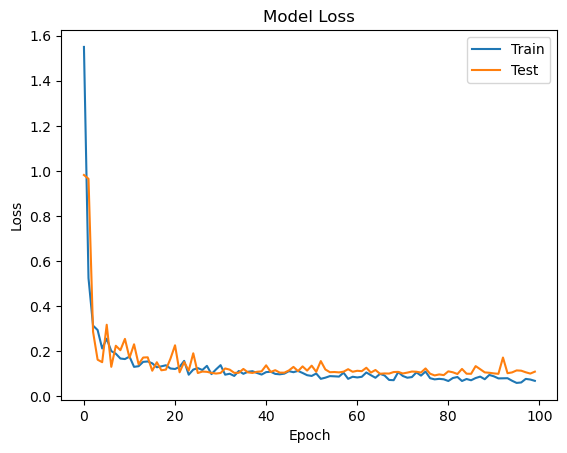

In [22]:
plot_loss(history)

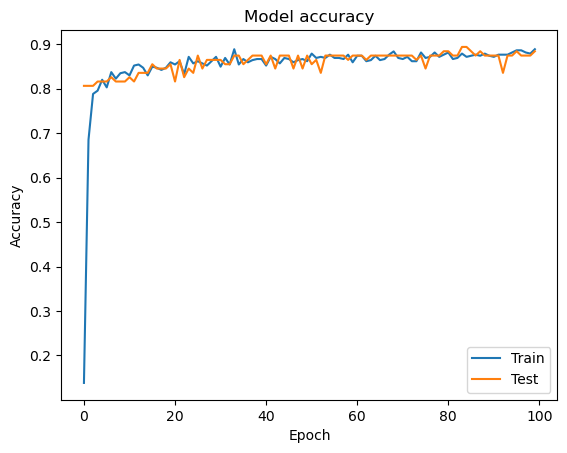

In [23]:
plot_acc(history)

In [26]:
lipnet.model.save('model.h5')